In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
import torchvision.models as models
from torchvision.models import resnet18
from tqdm import tqdm
#from transformers import BertModel, BertConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import torchvision.transforms
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score,average_precision_score, precision_recall_curve
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
#from utils import *
import logging
from torch.utils.tensorboard import SummaryWriter

import os
import numpy as np
import argparse
import configparser




In [ ]:
# Install some libaries for first use of the notebook
!pip install rasterio
!pip install Shapely==1.8.1.post1
!pip install scikit-image
!pip install -U efficientnet_pytorch
!pip install pytorch-metric-learning
!pip install -q timm
!pip install tqdm
!pip install ipywidgets
!pip install torchvision

In [ ]:
import warnings
from skimage import io, transform
from rasterio.features import rasterize # This is use to turn the geo graph into an bianry mask
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
import pickle
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from pytorch_metric_learning import losses
import copy

import albumentations as A
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [ ]:
# Load the Train, Validation, and Test Dataset as Dataframe

train_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\train.csv')
val_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\val.csv')
test_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.720266384577504_115.00699582064485
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.0223763234016


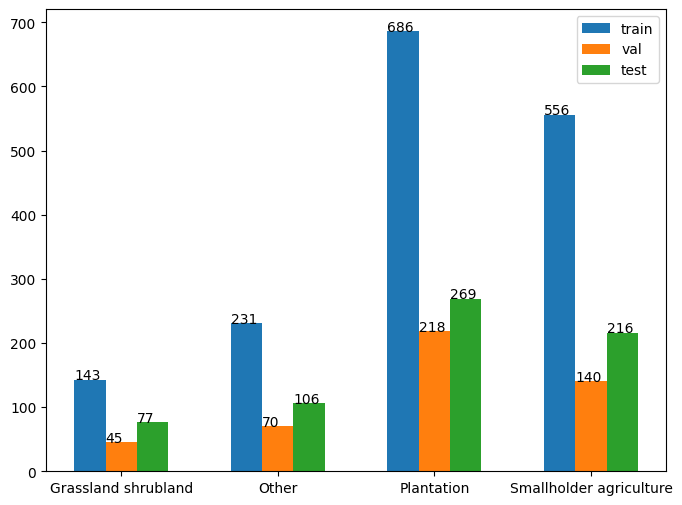

In [ ]:
# Dataset Specification

train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

In [ ]:
# Torch Dataset

class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir=r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset', transform=None, types="classifier", device = device):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {'Grassland shrubland': torch.asarray([1,0,0,0]), 'Other': torch.asarray([0,1,0,0]), 'Plantation': torch.asarray([0,0,1,0]), 'Smallholder agriculture': torch.asarray([0,0,0,1])}
        self.types = types
        self.device =device

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image = Image.open(f'{self.root_dir}/{folder}/images/visible/composite.png')#io.imread(f'{self.root_dir}/{folder}/images/visible/composite.png')
        image = self.transform(image)
        #slope = np.load(f'{self.root_dir}/{folder}/auxiliary/slope.npy')

        ## Get the segmentation map
        with open(f'{self.root_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)

        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)

        '''
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        '''


        image = image.to(self.device, dtype=torch.float32)#torch.from_numpy(image).to(self.device, dtype=torch.float32)
        #image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).to(self.device, dtype=torch.float32)
        #slope = torch.from_numpy(slope).type(torch.float)

        two_channel_seg = torch.zeros((2, seg.shape[0], seg.shape[1]), dtype=torch.float).to(self.device, dtype=torch.float32)

        # 将单通道掩码映射到两个通道
        two_channel_seg[0, :, :] = (seg == 0).float()  # 耕地的像素设为第一个通道的值
        two_channel_seg[1, :, :] = (seg == 1).float()  # 森林的像素设为第二个通道的值


        merged_label = self.label_to_int[merged_label]

        merged_label = merged_label.to(self.device, dtype=torch.float32)



        #image = image[:, 86:246, 86:246]
        seg = two_channel_seg[:, 52:276, 52:276]#seg[86:246, 86:246]
        #slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, merged_label, seg
        else:
            return image, merged_label, seg


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

In [ ]:
import torch.multiprocessing as mp

# Aid the mutliworkers for the dataloader

mp.set_start_method('spawn', force=True)


In [ ]:
# F1_Score_Dice Loss

def f_score(gt,pr, beta=1, eps=1e-7, threshold=None, activation="None"):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """



    '''
    if threshold is not None:
        pr = (pr > threshold).float()
    '''

    beta = 1
    gt = torch.argmax(gt, dim =1).float()
    pr = torch.argmax(pr, dim = 1).float()
    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return 1 - score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self,y_gt, y_pr):
        return 1 - f_score(y_pr, y_gt, beta=1.,
                           eps=self.eps, threshold=None,
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='None', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.CrossEntropyLoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_gt, y_pr):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce), dice


# Mainly used F1_Score and F1 Loss

def f1_loss(labels, outputs):
    # CalculateTrue Positives (TP)、False Positives (FP)和False Negatives (FN)
    TP = torch.sum(outputs[:, 1] * labels[:, 1])  # True Positives
    FP = torch.sum(outputs[:, 1] * (1 - labels[:, 1]))  # False Positives
    FN = torch.sum((1 - outputs[:, 1]) * labels[:, 1])  # False Negatives

    # Precision and Recall
    precision = TP / (TP + FP + 1e-6)  # Precision
    recall = TP / (TP + FN + 1e-6)  # Recall

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # F1 Score

    # F1 Loss
    f1_loss = 1 - f1  # F1 Loss

    return f1_loss

# Calculation of IOU, and IOU Loss

SMOOTH = 1e-6

def iou_pytorch(labels, outputs):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.argmax(outputs, dim=1).squeeze(1)
    labels = torch.argmax(labels, dim=1).squeeze(1)


    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return 1 - iou.mean()




In [ ]:
# Currently Not Used

#from transformers import Mask2FormerConfig, AutoImageProcessor, Mask2FormerForUniversalSegmentation
import torchvision.models
vgg16 = torchvision.models.vgg16(pretrained=True).to(device).features[:29]
vgg16.eval()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 256
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nbClass = 4

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=4),  # Decoder
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=4, padding=0),  # 上采样操作
            nn.Softmax2d()
        )

    def forward(self, x):
        # 解码器部分
        output = self.decoder(x)
        return output

# 创建模型
in_channels = 512
out_channels = 2
decoder = UNetDecoder(in_channels, out_channels).to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3) #, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)


number_of_epochs = 100

best_val_loss = float('inf')

runs = "total_run"

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    for i, (images, labels, seg) in enumerate(pbar):

      #Feature_Extraction_Model.eval()
      #inputs = processor(images=images, return_tensors="pt")
      vgg16.eval()
      with torch.no_grad():
          outputs = vgg16(images)

      #upsampled_features = outputs#.pixel_decoder_last_hidden_state

      optimizer.zero_grad()

      output_final = decoder(outputs)

      loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))

      tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)
      iou = iou_pytorch(seg, output_final)

      loss = loss+tp

      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        for i, (images, labels, seg) in enumerate(pbar):

            #Feature_Extraction_Model.eval()
            #inputs = processor(images=images, return_tensors="pt")
            vgg16.eval()
            with torch.no_grad():
                outputs = vgg16(images)

            #upsampled_features = outputs#.pixel_decoder_last_hidden_state


            output_final = decoder(outputs)

            loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))
            tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)
            iou = iou_pytorch(seg, output_final)

            loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            if val_loss < best_val_loss:

                best_val_loss = val_loss
                torch.save(decoder.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt.pt"))

        plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [ ]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

model = UNet(n_channels=3, n_classes=2).to(device)

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        x = self.mlp_head(x)

        x= self.softmax(x)
        return x #torch.sigmoid(x)

model_vit = ViT(
    image_size=(160, 160),
    patch_size=(16, 16),
    num_classes=4,  # 输出类别数
    dim=128,         # 模型维度
    depth=6,         # Transformer层的深度
    heads=8,         # 注意力头的数量
    mlp_dim=256,     # MLP的隐藏层维度
    pool='cls',      # 池化方式，可以是'cls'或'mean'
    channels=3,  # 输入图像通道数
    dim_head=64,     # 注意力头的维度
    dropout=0,     # Dropout概率
    emb_dropout=0  # 嵌入层的Dropout概率
).to(device)

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim_q=160, dim_k=160, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inner_dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm_q = nn.LayerNorm(dim_q)
        self.norm_k = nn.LayerNorm(dim_k)

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim_q, inner_dim, bias=False)
        self.to_k = nn.Linear(dim_k, inner_dim, bias=False)
        self.to_v = nn.Linear(dim_k, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim_q),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, q, k):
        q = self.norm_q(q)
        k = self.norm_k(k)

        q, k, v = self.to_q(q), self.to_k(k), self.to_v(k)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, img, info):
        x = self.to_patch_embedding(img)
        x_k = info
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, x_k)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        x = self.mlp_head(x)

        x= self.softmax(x)
        return x #torch.sigmoid(x)

model_vit = ViT(
    image_size=(160, 160),
    patch_size=(16, 16),
    num_classes=3,  # 输出类别数
    dim=128,         # 模型维度
    depth=6,         # Transformer层的深度
    heads=8,         # 注意力头的数量
    mlp_dim=256,     # MLP的隐藏层维度
    pool='cls',      # 池化方式，可以是'cls'或'mean'
    channels=3,  # 输入图像通道数
    dim_head=64,     # 注意力头的维度
    dropout=0,     # Dropout概率
    emb_dropout=0  # 嵌入层的Dropout概率
).to(device)

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim_q, dim_k, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inner_dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm_q = nn.LayerNorm(dim_q)
        self.norm_k = nn.LayerNorm(dim_k)

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim_q, inner_dim, bias=False)
        self.to_k = nn.Linear(dim_k, inner_dim, bias=False)
        self.to_v = nn.Linear(dim_k, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim_q),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, q, k):
        q = self.norm_q(q)
        k = self.norm_k(k)

        q, k, v = self.to_q(q), self.to_k(k), self.to_v(k)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        return self.to_out(out)


In [ ]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第二个卷积层
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全连接层
        self.fc1 = nn.Linear(32 * 40 * 40, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)  # 4 是输出类别数量
        #self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # 展平

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x= self.softmax(x)

        return x

# 创建模型实例
cls_model = CNNClassifier().to(device)



# 输出形状为 (batch_size, 4)，表示每个样本对应的类别分数


In [ ]:
import torch.nn as nn
import torchvision.models as models

class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)

        # 修改第一个卷积层以适应5个输入通道
        self.resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # 更新最后一层以适应你的任务
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# 创建一个输入通道为5，输出类别为num_classes的模型
num_classes = 4  # 替换为你的类别数量
cls_model = ModifiedResNet50(num_classes)

cls_model = nn.Sequential(
    cls_model,
    nn.Softmax(dim = 1)  # 添加 sigmoid 层
).to(device)




In [ ]:
import torch.nn as nn
import timm

# 使用 timm 创建一个预训练的 ResNet-18 模型
cls_model = timm.create_model('resnet50', pretrained=True)

# 获取原始模型的分类器中的输入特征数
num_ftrs = cls_model.get_classifier().in_features

# 修改模型的第一层卷积层，将输入通道数从3更改为5
cls_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 修改模型的全连接层，以适应你的任务（这里假设输出类别数为4）
cls_model.fc = nn.Linear(num_ftrs, 4)

cls_model = nn.Sequential(
    cls_model,
    nn.Softmax(dim = 1)  # 添加 sigmoid 层
).to(device)

cls_model = cls_model.to(device)



In [ ]:
timm.list_models()

In [ ]:
import timm
import torch

# 指定模型名称和预训练权重
model_name = 'mobilevitv2_050' #'vit_base_patch16_224'  # 选择适合你任务的模型
pretrained = True  # 使用预训练权重

# 创建ViT模型
timm_vit_model = timm.create_model(model_name, pretrained=pretrained, num_classes=4).to(device)

In [ ]:
# For Drivers Classification

from sklearn.metrics import f1_score


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(timm_vit_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    timm_vit_model.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images + output_seg

      outputs = timm_vit_model(output_final)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp
      outputs = torch.nn.functional.softmax(outputs, dim = -1)
      outputs = torch.argmax(outputs,dim= -1).squeeze()
      labels = torch.argmax(labels,dim= -1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      f1 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), average='macro')

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy, Train_F1_Score = f1)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        timm_vit_model.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images + output_seg

            outputs = timm_vit_model(output_final)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.nn.functional.softmax(outputs, dim = -1)

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            f1 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), average='macro')

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': timm_vit_model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new_seperate_img_and_seg.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [ ]:
# For Segmentation

from sklearn.metrics import f1_score

import timm
import torch
import torch.nn as nn

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x

# 指定模型名称和类别数
model_name = 'resnet50'  # 选择适合你任务的模型，可以根据需要更改
num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_for_seg_new_2_tr.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])

segmentation_model.load_state_dict(checkpoint['model_state_dict'])


optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss() #nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(valloader)
    train_loss = 0
    acc = 0
    segmentation_model.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      outputs = segmentation_model(images)#(images, output_seg)#(output_final)

      loss = criterion(seg, outputs)

      outputs = torch.nn.functional.softmax(outputs, dim = 1)


      tp = f1_loss(seg, outputs) #iou_pytorch(seg, output_final)

      iou = iou_pytorch(seg, outputs)

      #loss = loss+tp


      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())#, Train_Accuracy = accuracy, Train_F1_Score = f1)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        segmentation_model.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            outputs = segmentation_model(images)#(images, output_seg)#(output_final)

            loss = criterion(seg, outputs)

            outputs = torch.nn.functional.softmax(outputs, dim = 1)

            tp = f1_loss(seg, outputs)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, outputs)

            #loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())#, Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss



            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': segmentation_model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_for_seg_new_2_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.603, VAL_F1_Loss=0.695, Val_Loss=0.0175]


###### Epoch:  0 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.604, VAL_F1_Loss=0.606, Val_Loss=0.0252]


###### Epoch:  1 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.626, VAL_F1_Loss=0.765, Val_Loss=0.0193]


###### Epoch:  2 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.04it/s, IOU=0.636, VAL_F1_Loss=0.828, Val_Loss=0.0138]


###### Epoch:  3 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.543, VAL_F1_Loss=0.686, Val_Loss=0.0231]


###### Epoch:  4 _ 0.0  ######


100%|██████████| 15/15 [00:10<00:00,  1.49it/s, IOU=0.72, VAL_F1_Loss=0.693, Val_Loss=0.0181] 


###### Epoch:  5 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.453, VAL_F1_Loss=0.619, Val_Loss=0.0274]


###### Epoch:  6 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.695, VAL_F1_Loss=0.86, Val_Loss=0.0155] 


###### Epoch:  7 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.514, VAL_F1_Loss=0.584, Val_Loss=0.0256]


###### Epoch:  8 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.49, VAL_F1_Loss=0.695, Val_Loss=0.0296] 


###### Epoch:  9 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.587, VAL_F1_Loss=0.793, Val_Loss=0.0156]


###### Epoch:  10 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.651, VAL_F1_Loss=0.765, Val_Loss=0.0176]


###### Epoch:  11 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.552, VAL_F1_Loss=0.643, Val_Loss=0.0212]


###### Epoch:  12 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.69, VAL_F1_Loss=0.702, Val_Loss=0.0151] 


###### Epoch:  13 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.553, VAL_F1_Loss=0.768, Val_Loss=0.0177]


###### Epoch:  14 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.615, VAL_F1_Loss=0.881, Val_Loss=0.014] 


###### Epoch:  15 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.495, VAL_F1_Loss=0.667, Val_Loss=0.0264]


###### Epoch:  16 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.635, VAL_F1_Loss=0.771, Val_Loss=0.0238]


###### Epoch:  17 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.643, VAL_F1_Loss=0.921, Val_Loss=0.01]  


###### Epoch:  18 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.46, VAL_F1_Loss=0.623, Val_Loss=0.0228] 


###### Epoch:  19 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.768, VAL_F1_Loss=0.906, Val_Loss=0.00956]


###### Epoch:  20 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.682, VAL_F1_Loss=0.806, Val_Loss=0.0151]


###### Epoch:  21 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.477, VAL_F1_Loss=0.664, Val_Loss=0.0228]


###### Epoch:  22 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.57, VAL_F1_Loss=0.772, Val_Loss=0.0184] 


###### Epoch:  23 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.683, VAL_F1_Loss=0.655, Val_Loss=0.0226]


###### Epoch:  24 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.567, VAL_F1_Loss=0.683, Val_Loss=0.0194]


###### Epoch:  25 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.681, VAL_F1_Loss=0.836, Val_Loss=0.0118]


###### Epoch:  26 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.593, VAL_F1_Loss=0.618, Val_Loss=0.0221]


###### Epoch:  27 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.592, VAL_F1_Loss=0.709, Val_Loss=0.0183]


###### Epoch:  28 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.564, VAL_F1_Loss=0.678, Val_Loss=0.0307]


###### Epoch:  29 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.656, VAL_F1_Loss=0.65, Val_Loss=0.0239] 


###### Epoch:  30 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.696, VAL_F1_Loss=0.737, Val_Loss=0.015] 


###### Epoch:  31 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.568, VAL_F1_Loss=0.743, Val_Loss=0.0237]


###### Epoch:  32 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.592, VAL_F1_Loss=0.677, Val_Loss=0.0226]


###### Epoch:  33 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.648, VAL_F1_Loss=0.752, Val_Loss=0.022] 


###### Epoch:  34 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.612, VAL_F1_Loss=0.693, Val_Loss=0.0209]


###### Epoch:  35 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.555, VAL_F1_Loss=0.682, Val_Loss=0.0207]


###### Epoch:  36 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.649, VAL_F1_Loss=0.73, Val_Loss=0.0201] 


###### Epoch:  37 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.615, VAL_F1_Loss=0.785, Val_Loss=0.0195]


###### Epoch:  38 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.641, VAL_F1_Loss=0.664, Val_Loss=0.0223]


###### Epoch:  39 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.614, VAL_F1_Loss=0.706, Val_Loss=0.028] 


###### Epoch:  40 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.546, VAL_F1_Loss=0.684, Val_Loss=0.0224]


###### Epoch:  41 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.589, VAL_F1_Loss=0.649, Val_Loss=0.0235]


###### Epoch:  42 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.584, VAL_F1_Loss=0.711, Val_Loss=0.0256]


###### Epoch:  43 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.537, VAL_F1_Loss=0.632, Val_Loss=0.0206]


###### Epoch:  44 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.596, VAL_F1_Loss=0.777, Val_Loss=0.0222]


###### Epoch:  45 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.605, VAL_F1_Loss=0.688, Val_Loss=0.0219]


###### Epoch:  46 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.642, VAL_F1_Loss=0.685, Val_Loss=0.0285]


###### Epoch:  47 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.62, VAL_F1_Loss=0.723, Val_Loss=0.0153] 


###### Epoch:  48 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.514, VAL_F1_Loss=0.614, Val_Loss=0.0275]


###### Epoch:  49 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.575, VAL_F1_Loss=0.739, Val_Loss=0.0239]


###### Epoch:  50 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.521, VAL_F1_Loss=0.686, Val_Loss=0.0202]


###### Epoch:  51 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.581, VAL_F1_Loss=0.812, Val_Loss=0.0228]


###### Epoch:  52 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.617, VAL_F1_Loss=0.772, Val_Loss=0.0211]


###### Epoch:  53 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.531, VAL_F1_Loss=0.585, Val_Loss=0.0263]


###### Epoch:  54 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.57, VAL_F1_Loss=0.736, Val_Loss=0.0176] 


###### Epoch:  55 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.62, VAL_F1_Loss=0.829, Val_Loss=0.0143] 


###### Epoch:  56 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.63, VAL_F1_Loss=0.701, Val_Loss=0.0163] 


###### Epoch:  57 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.688, VAL_F1_Loss=0.889, Val_Loss=0.0114]


###### Epoch:  58 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.584, VAL_F1_Loss=0.743, Val_Loss=0.0222]


###### Epoch:  59 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.669, VAL_F1_Loss=0.661, Val_Loss=0.0197]


###### Epoch:  60 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.605, VAL_F1_Loss=0.753, Val_Loss=0.021] 


###### Epoch:  61 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.567, VAL_F1_Loss=0.794, Val_Loss=0.015] 


###### Epoch:  62 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.591, VAL_F1_Loss=0.731, Val_Loss=0.0236]


###### Epoch:  63 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.619, VAL_F1_Loss=0.625, Val_Loss=0.0261]


###### Epoch:  64 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.72, VAL_F1_Loss=0.862, Val_Loss=0.014]  


###### Epoch:  65 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.57, VAL_F1_Loss=0.692, Val_Loss=0.0297] 


###### Epoch:  66 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.615, VAL_F1_Loss=0.704, Val_Loss=0.0216]


###### Epoch:  67 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.596, VAL_F1_Loss=0.676, Val_Loss=0.0147]


###### Epoch:  68 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.671, VAL_F1_Loss=0.817, Val_Loss=0.0142]


###### Epoch:  69 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.436, VAL_F1_Loss=0.548, Val_Loss=0.0307]


###### Epoch:  70 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.525, VAL_F1_Loss=0.667, Val_Loss=0.0269]


###### Epoch:  71 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.623, VAL_F1_Loss=0.68, Val_Loss=0.0197] 


###### Epoch:  72 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.587, VAL_F1_Loss=0.678, Val_Loss=0.0216]


###### Epoch:  73 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.675, VAL_F1_Loss=0.775, Val_Loss=0.0115]


###### Epoch:  74 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.479, VAL_F1_Loss=0.59, Val_Loss=0.033]  


###### Epoch:  75 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.636, VAL_F1_Loss=0.861, Val_Loss=0.0134]


###### Epoch:  76 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.616, VAL_F1_Loss=0.746, Val_Loss=0.0221]


###### Epoch:  77 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.575, VAL_F1_Loss=0.758, Val_Loss=0.0201]


###### Epoch:  78 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.607, VAL_F1_Loss=0.717, Val_Loss=0.0243]


###### Epoch:  79 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.652, VAL_F1_Loss=0.803, Val_Loss=0.0167]


###### Epoch:  80 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.541, VAL_F1_Loss=0.777, Val_Loss=0.0201]


###### Epoch:  81 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.629, VAL_F1_Loss=0.776, Val_Loss=0.0157]


###### Epoch:  82 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.62, VAL_F1_Loss=0.654, Val_Loss=0.0264] 


###### Epoch:  83 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.732, VAL_F1_Loss=0.914, Val_Loss=0.0094]


###### Epoch:  84 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.669, VAL_F1_Loss=0.743, Val_Loss=0.0166]


###### Epoch:  85 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.52it/s, IOU=0.688, VAL_F1_Loss=0.836, Val_Loss=0.0184]


###### Epoch:  86 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.605, VAL_F1_Loss=0.818, Val_Loss=0.0156]


###### Epoch:  87 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.595, VAL_F1_Loss=0.659, Val_Loss=0.0254]


###### Epoch:  88 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.677, VAL_F1_Loss=0.804, Val_Loss=0.0177]


###### Epoch:  89 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.608, VAL_F1_Loss=0.793, Val_Loss=0.018] 


###### Epoch:  90 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.6, VAL_F1_Loss=0.728, Val_Loss=0.0141]  


###### Epoch:  91 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.551, VAL_F1_Loss=0.687, Val_Loss=0.0237]


###### Epoch:  92 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.519, VAL_F1_Loss=0.654, Val_Loss=0.0223]


###### Epoch:  93 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.514, VAL_F1_Loss=0.74, Val_Loss=0.0225] 


###### Epoch:  94 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.625, VAL_F1_Loss=0.748, Val_Loss=0.0158]


###### Epoch:  95 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.598, VAL_F1_Loss=0.779, Val_Loss=0.0238]


###### Epoch:  96 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.541, VAL_F1_Loss=0.574, Val_Loss=0.0256]


###### Epoch:  97 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.539, VAL_F1_Loss=0.703, Val_Loss=0.0177]


###### Epoch:  98 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.508, VAL_F1_Loss=0.612, Val_Loss=0.028] 


###### Epoch:  99 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.582, VAL_F1_Loss=0.665, Val_Loss=0.0245]


###### Epoch:  100 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.682, VAL_F1_Loss=0.797, Val_Loss=0.0161]


###### Epoch:  101 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.619, VAL_F1_Loss=0.702, Val_Loss=0.0191]


###### Epoch:  102 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.702, VAL_F1_Loss=0.734, Val_Loss=0.00913]


###### Epoch:  103 _ 0.0  ######


100%|██████████| 15/15 [00:08<00:00,  1.78it/s, IOU=0.701, VAL_F1_Loss=0.81, Val_Loss=0.0168] 


###### Epoch:  104 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  1.94it/s, IOU=0.609, VAL_F1_Loss=0.681, Val_Loss=0.0212]


###### Epoch:  105 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.605, VAL_F1_Loss=0.747, Val_Loss=0.0239]


###### Epoch:  106 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.637, VAL_F1_Loss=0.73, Val_Loss=0.0178] 


###### Epoch:  107 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.578, VAL_F1_Loss=0.626, Val_Loss=0.0234]


###### Epoch:  108 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.602, VAL_F1_Loss=0.704, Val_Loss=0.0223]


###### Epoch:  109 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.566, VAL_F1_Loss=0.769, Val_Loss=0.0217]


###### Epoch:  110 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.478, VAL_F1_Loss=0.584, Val_Loss=0.0286]


###### Epoch:  111 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.567, VAL_F1_Loss=0.754, Val_Loss=0.0232]


###### Epoch:  112 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.525, VAL_F1_Loss=0.621, Val_Loss=0.029] 


###### Epoch:  113 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.697, VAL_F1_Loss=0.752, Val_Loss=0.0143]


###### Epoch:  114 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.572, VAL_F1_Loss=0.745, Val_Loss=0.0195]


###### Epoch:  115 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  1.95it/s, IOU=0.507, VAL_F1_Loss=0.714, Val_Loss=0.0212]


###### Epoch:  116 _ 0.0  ######


100%|██████████| 15/15 [00:08<00:00,  1.70it/s, IOU=0.575, VAL_F1_Loss=0.658, Val_Loss=0.0263]


###### Epoch:  117 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.59, VAL_F1_Loss=0.632, Val_Loss=0.0252] 


###### Epoch:  118 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.09it/s, IOU=0.517, VAL_F1_Loss=0.585, Val_Loss=0.026] 


###### Epoch:  119 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.753, VAL_F1_Loss=0.885, Val_Loss=0.0138]


###### Epoch:  120 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.647, VAL_F1_Loss=0.682, Val_Loss=0.0177]


###### Epoch:  121 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.601, VAL_F1_Loss=0.674, Val_Loss=0.0215]


###### Epoch:  122 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.637, VAL_F1_Loss=0.822, Val_Loss=0.0163]


###### Epoch:  123 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.22it/s, IOU=0.615, VAL_F1_Loss=0.696, Val_Loss=0.028] 


###### Epoch:  124 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.681, VAL_F1_Loss=0.73, Val_Loss=0.0235] 


###### Epoch:  125 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.599, VAL_F1_Loss=0.727, Val_Loss=0.0157]


###### Epoch:  126 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.37it/s, IOU=0.558, VAL_F1_Loss=0.646, Val_Loss=0.0226]


###### Epoch:  127 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.616, VAL_F1_Loss=0.599, Val_Loss=0.0184]


###### Epoch:  128 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.727, VAL_F1_Loss=0.823, Val_Loss=0.0125]


###### Epoch:  129 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.14it/s, IOU=0.58, VAL_F1_Loss=0.671, Val_Loss=0.0285] 


###### Epoch:  130 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.639, VAL_F1_Loss=0.695, Val_Loss=0.0202]


###### Epoch:  131 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.676, VAL_F1_Loss=0.679, Val_Loss=0.0223]


###### Epoch:  132 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.518, VAL_F1_Loss=0.631, Val_Loss=0.034] 


###### Epoch:  133 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.628, VAL_F1_Loss=0.789, Val_Loss=0.018] 


###### Epoch:  134 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.629, VAL_F1_Loss=0.729, Val_Loss=0.0215]


###### Epoch:  135 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.635, VAL_F1_Loss=0.759, Val_Loss=0.0194]


###### Epoch:  136 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.461, VAL_F1_Loss=0.603, Val_Loss=0.0217]


###### Epoch:  137 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.735, VAL_F1_Loss=0.738, Val_Loss=0.0154]


###### Epoch:  138 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.74, VAL_F1_Loss=0.827, Val_Loss=0.0151] 


###### Epoch:  139 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.596, VAL_F1_Loss=0.688, Val_Loss=0.0256]


###### Epoch:  140 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.494, VAL_F1_Loss=0.637, Val_Loss=0.0282]


###### Epoch:  141 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.581, VAL_F1_Loss=0.637, Val_Loss=0.0214]


###### Epoch:  142 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.66, VAL_F1_Loss=0.751, Val_Loss=0.026]  


###### Epoch:  143 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.684, VAL_F1_Loss=0.884, Val_Loss=0.0113]


###### Epoch:  144 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.585, VAL_F1_Loss=0.723, Val_Loss=0.0161]


###### Epoch:  145 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.501, VAL_F1_Loss=0.691, Val_Loss=0.0305]


###### Epoch:  146 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.512, VAL_F1_Loss=0.573, Val_Loss=0.0308]


###### Epoch:  147 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.614, VAL_F1_Loss=0.631, Val_Loss=0.0251]


###### Epoch:  148 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.635, VAL_F1_Loss=0.789, Val_Loss=0.0189]


###### Epoch:  149 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.56, VAL_F1_Loss=0.678, Val_Loss=0.0267] 


###### Epoch:  150 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.595, VAL_F1_Loss=0.682, Val_Loss=0.0249]


###### Epoch:  151 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.682, VAL_F1_Loss=0.775, Val_Loss=0.0106]


###### Epoch:  152 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.597, VAL_F1_Loss=0.584, Val_Loss=0.0228]


###### Epoch:  153 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.698, VAL_F1_Loss=0.837, Val_Loss=0.019] 


###### Epoch:  154 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.605, VAL_F1_Loss=0.625, Val_Loss=0.0207]


###### Epoch:  155 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.55, VAL_F1_Loss=0.687, Val_Loss=0.0217] 


###### Epoch:  156 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.597, VAL_F1_Loss=0.772, Val_Loss=0.02]  


###### Epoch:  157 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.581, VAL_F1_Loss=0.785, Val_Loss=0.0204]


###### Epoch:  158 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.601, VAL_F1_Loss=0.792, Val_Loss=0.0208]


###### Epoch:  159 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.635, VAL_F1_Loss=0.729, Val_Loss=0.0157]


###### Epoch:  160 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.614, VAL_F1_Loss=0.718, Val_Loss=0.0173]


###### Epoch:  161 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.613, VAL_F1_Loss=0.615, Val_Loss=0.0178]


###### Epoch:  162 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.612, VAL_F1_Loss=0.757, Val_Loss=0.0287]


###### Epoch:  163 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.547, VAL_F1_Loss=0.681, Val_Loss=0.0208]


###### Epoch:  164 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.512, VAL_F1_Loss=0.613, Val_Loss=0.0268]


###### Epoch:  165 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.68, VAL_F1_Loss=0.741, Val_Loss=0.0143] 


###### Epoch:  166 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.657, VAL_F1_Loss=0.77, Val_Loss=0.0197] 


###### Epoch:  167 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.587, VAL_F1_Loss=0.614, Val_Loss=0.0191]


###### Epoch:  168 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.744, VAL_F1_Loss=0.848, Val_Loss=0.0117]


###### Epoch:  169 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.671, VAL_F1_Loss=0.868, Val_Loss=0.0139]


###### Epoch:  170 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.624, VAL_F1_Loss=0.733, Val_Loss=0.0167]


###### Epoch:  171 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.637, VAL_F1_Loss=0.671, Val_Loss=0.0194]


###### Epoch:  172 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.598, VAL_F1_Loss=0.736, Val_Loss=0.0238]


###### Epoch:  173 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.599, VAL_F1_Loss=0.81, Val_Loss=0.0154] 


###### Epoch:  174 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.564, VAL_F1_Loss=0.646, Val_Loss=0.0262]


###### Epoch:  175 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.572, VAL_F1_Loss=0.745, Val_Loss=0.0235]


###### Epoch:  176 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.687, VAL_F1_Loss=0.794, Val_Loss=0.0141]


###### Epoch:  177 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.682, VAL_F1_Loss=0.813, Val_Loss=0.0124]


###### Epoch:  178 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.693, VAL_F1_Loss=0.839, Val_Loss=0.015] 


###### Epoch:  179 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.534, VAL_F1_Loss=0.716, Val_Loss=0.0245]


###### Epoch:  180 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.613, VAL_F1_Loss=0.703, Val_Loss=0.0169]


###### Epoch:  181 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.53it/s, IOU=0.598, VAL_F1_Loss=0.755, Val_Loss=0.0213]


###### Epoch:  182 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.598, VAL_F1_Loss=0.641, Val_Loss=0.0252]


###### Epoch:  183 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.651, VAL_F1_Loss=0.801, Val_Loss=0.0164]


###### Epoch:  184 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.619, VAL_F1_Loss=0.77, Val_Loss=0.0135] 


###### Epoch:  185 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.506, VAL_F1_Loss=0.695, Val_Loss=0.0309]


###### Epoch:  186 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.631, VAL_F1_Loss=0.727, Val_Loss=0.0192]


###### Epoch:  187 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.581, VAL_F1_Loss=0.739, Val_Loss=0.0202]


###### Epoch:  188 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.496, VAL_F1_Loss=0.522, Val_Loss=0.0323]


###### Epoch:  189 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.587, VAL_F1_Loss=0.666, Val_Loss=0.0243]


###### Epoch:  190 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.596, VAL_F1_Loss=0.765, Val_Loss=0.0203]


###### Epoch:  191 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.649, VAL_F1_Loss=0.692, Val_Loss=0.0109]


###### Epoch:  192 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.555, VAL_F1_Loss=0.599, Val_Loss=0.0226]


###### Epoch:  193 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.677, VAL_F1_Loss=0.813, Val_Loss=0.0184]


###### Epoch:  194 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.562, VAL_F1_Loss=0.644, Val_Loss=0.0247]


###### Epoch:  195 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.644, VAL_F1_Loss=0.804, Val_Loss=0.0166]


###### Epoch:  196 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.59, VAL_F1_Loss=0.642, Val_Loss=0.0313] 


###### Epoch:  197 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.58, VAL_F1_Loss=0.673, Val_Loss=0.0274] 


###### Epoch:  198 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.621, VAL_F1_Loss=0.716, Val_Loss=0.0187]


###### Epoch:  199 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.626, VAL_F1_Loss=0.687, Val_Loss=0.0228]


###### Epoch:  200 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.498, VAL_F1_Loss=0.637, Val_Loss=0.0319]


###### Epoch:  201 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.59, VAL_F1_Loss=0.689, Val_Loss=0.0168] 


###### Epoch:  202 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.663, VAL_F1_Loss=0.809, Val_Loss=0.0189]


###### Epoch:  203 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.662, VAL_F1_Loss=0.842, Val_Loss=0.0129]


###### Epoch:  204 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.657, VAL_F1_Loss=0.745, Val_Loss=0.0184]


###### Epoch:  205 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.639, VAL_F1_Loss=0.883, Val_Loss=0.0134]


###### Epoch:  206 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.645, VAL_F1_Loss=0.758, Val_Loss=0.0216]


###### Epoch:  207 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.538, VAL_F1_Loss=0.637, Val_Loss=0.0241]


###### Epoch:  208 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.515, VAL_F1_Loss=0.676, Val_Loss=0.0236]


###### Epoch:  209 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.61it/s, IOU=0.567, VAL_F1_Loss=0.624, Val_Loss=0.0247]


###### Epoch:  210 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.588, VAL_F1_Loss=0.683, Val_Loss=0.0227]


###### Epoch:  211 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.539, VAL_F1_Loss=0.744, Val_Loss=0.0252]


###### Epoch:  212 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.62, VAL_F1_Loss=0.745, Val_Loss=0.0145] 


###### Epoch:  213 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.699, VAL_F1_Loss=0.817, Val_Loss=0.0149]


###### Epoch:  214 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.593, VAL_F1_Loss=0.76, Val_Loss=0.0178] 


###### Epoch:  215 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.522, VAL_F1_Loss=0.649, Val_Loss=0.0234]


###### Epoch:  216 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.601, VAL_F1_Loss=0.729, Val_Loss=0.0211]


###### Epoch:  217 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.563, VAL_F1_Loss=0.802, Val_Loss=0.0177]


###### Epoch:  218 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.622, VAL_F1_Loss=0.689, Val_Loss=0.0266]


###### Epoch:  219 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.655, VAL_F1_Loss=0.761, Val_Loss=0.0256]


###### Epoch:  220 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.493, VAL_F1_Loss=0.606, Val_Loss=0.0185]


###### Epoch:  221 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.554, VAL_F1_Loss=0.695, Val_Loss=0.0304]


###### Epoch:  222 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.636, VAL_F1_Loss=0.729, Val_Loss=0.0154]


###### Epoch:  223 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.635, VAL_F1_Loss=0.767, Val_Loss=0.0164]


###### Epoch:  224 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.569, VAL_F1_Loss=0.702, Val_Loss=0.0254]


###### Epoch:  225 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.657, VAL_F1_Loss=0.667, Val_Loss=0.0201]


###### Epoch:  226 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.566, VAL_F1_Loss=0.693, Val_Loss=0.0333]


###### Epoch:  227 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.641, VAL_F1_Loss=0.853, Val_Loss=0.014] 


###### Epoch:  228 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.61, VAL_F1_Loss=0.66, Val_Loss=0.0183]  


###### Epoch:  229 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.592, VAL_F1_Loss=0.757, Val_Loss=0.0174]


###### Epoch:  230 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.569, VAL_F1_Loss=0.7, Val_Loss=0.0283]  


###### Epoch:  231 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.603, VAL_F1_Loss=0.793, Val_Loss=0.0199]


###### Epoch:  232 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.602, VAL_F1_Loss=0.765, Val_Loss=0.0222]


###### Epoch:  233 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.707, VAL_F1_Loss=0.7, Val_Loss=0.0171]  


###### Epoch:  234 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.551, VAL_F1_Loss=0.643, Val_Loss=0.021] 


###### Epoch:  235 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.569, VAL_F1_Loss=0.793, Val_Loss=0.0189]


###### Epoch:  236 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.584, VAL_F1_Loss=0.717, Val_Loss=0.0232]


###### Epoch:  237 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.582, VAL_F1_Loss=0.663, Val_Loss=0.0182]


###### Epoch:  238 _ 0.0  ######


100%|██████████| 15/15 [00:10<00:00,  1.49it/s, IOU=0.671, VAL_F1_Loss=0.809, Val_Loss=0.0202]


###### Epoch:  239 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.554, VAL_F1_Loss=0.842, Val_Loss=0.0139]


###### Epoch:  240 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.556, VAL_F1_Loss=0.609, Val_Loss=0.0233]


###### Epoch:  241 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.607, VAL_F1_Loss=0.763, Val_Loss=0.02]  


###### Epoch:  242 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.588, VAL_F1_Loss=0.627, Val_Loss=0.0147]


###### Epoch:  243 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.653, VAL_F1_Loss=0.783, Val_Loss=0.0151]


###### Epoch:  244 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.612, VAL_F1_Loss=0.836, Val_Loss=0.0126]


###### Epoch:  245 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.598, VAL_F1_Loss=0.63, Val_Loss=0.0266]  


###### Epoch:  246 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.586, VAL_F1_Loss=0.692, Val_Loss=0.0183]


###### Epoch:  247 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.573, VAL_F1_Loss=0.631, Val_Loss=0.0215]


###### Epoch:  248 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.564, VAL_F1_Loss=0.728, Val_Loss=0.0227]


###### Epoch:  249 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.511, VAL_F1_Loss=0.612, Val_Loss=0.0253]


###### Epoch:  250 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.36it/s, IOU=0.67, VAL_F1_Loss=0.744, Val_Loss=0.0183] 


###### Epoch:  251 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.675, VAL_F1_Loss=0.792, Val_Loss=0.0176]


###### Epoch:  252 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.642, VAL_F1_Loss=0.75, Val_Loss=0.0214] 


###### Epoch:  253 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.602, VAL_F1_Loss=0.696, Val_Loss=0.0216]


###### Epoch:  254 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.587, VAL_F1_Loss=0.835, Val_Loss=0.0156]


###### Epoch:  255 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.569, VAL_F1_Loss=0.777, Val_Loss=0.0194]


###### Epoch:  256 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.563, VAL_F1_Loss=0.644, Val_Loss=0.0223]


###### Epoch:  257 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.663, VAL_F1_Loss=0.843, Val_Loss=0.0172]


###### Epoch:  258 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.549, VAL_F1_Loss=0.772, Val_Loss=0.0203]


###### Epoch:  259 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.601, VAL_F1_Loss=0.792, Val_Loss=0.0188]


###### Epoch:  260 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.678, VAL_F1_Loss=0.829, Val_Loss=0.018] 


###### Epoch:  261 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.626, VAL_F1_Loss=0.765, Val_Loss=0.0216]


###### Epoch:  262 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.605, VAL_F1_Loss=0.702, Val_Loss=0.0229]


###### Epoch:  263 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.586, VAL_F1_Loss=0.684, Val_Loss=0.0169]


###### Epoch:  264 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.638, VAL_F1_Loss=0.669, Val_Loss=0.0197]


###### Epoch:  265 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, IOU=0.642, VAL_F1_Loss=0.786, Val_Loss=0.0212]


###### Epoch:  266 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.699, VAL_F1_Loss=0.887, Val_Loss=0.0116]


###### Epoch:  267 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.741, VAL_F1_Loss=0.845, Val_Loss=0.0131]


###### Epoch:  268 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.644, VAL_F1_Loss=0.722, Val_Loss=0.0247]


###### Epoch:  269 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.554, VAL_F1_Loss=0.667, Val_Loss=0.0262]


###### Epoch:  270 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.575, VAL_F1_Loss=0.635, Val_Loss=0.0167]


###### Epoch:  271 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.729, VAL_F1_Loss=0.853, Val_Loss=0.0157]


###### Epoch:  272 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.544, VAL_F1_Loss=0.681, Val_Loss=0.0221]


###### Epoch:  273 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.545, VAL_F1_Loss=0.829, Val_Loss=0.0185]


###### Epoch:  274 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.591, VAL_F1_Loss=0.734, Val_Loss=0.0216]


###### Epoch:  275 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.561, VAL_F1_Loss=0.707, Val_Loss=0.0197]


###### Epoch:  276 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.744, VAL_F1_Loss=0.77, Val_Loss=0.0123] 


###### Epoch:  277 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.412, VAL_F1_Loss=0.657, Val_Loss=0.0317]


###### Epoch:  278 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.474, VAL_F1_Loss=0.602, Val_Loss=0.0337]


###### Epoch:  279 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.635, VAL_F1_Loss=0.736, Val_Loss=0.0185]


###### Epoch:  280 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.724, VAL_F1_Loss=0.713, Val_Loss=0.0146]


###### Epoch:  281 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.621, VAL_F1_Loss=0.764, Val_Loss=0.0228]


###### Epoch:  282 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.625, VAL_F1_Loss=0.785, Val_Loss=0.0175]


###### Epoch:  283 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.695, VAL_F1_Loss=0.793, Val_Loss=0.0133]


###### Epoch:  284 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.686, VAL_F1_Loss=0.838, Val_Loss=0.0197]


###### Epoch:  285 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.591, VAL_F1_Loss=0.637, Val_Loss=0.0211]


###### Epoch:  286 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.649, VAL_F1_Loss=0.854, Val_Loss=0.0136]


###### Epoch:  287 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.599, VAL_F1_Loss=0.703, Val_Loss=0.0256]


###### Epoch:  288 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.608, VAL_F1_Loss=0.729, Val_Loss=0.0215]


###### Epoch:  289 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.602, VAL_F1_Loss=0.698, Val_Loss=0.0214]


###### Epoch:  290 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.617, VAL_F1_Loss=0.742, Val_Loss=0.0215]


###### Epoch:  291 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.548, VAL_F1_Loss=0.652, Val_Loss=0.0166]


###### Epoch:  292 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.529, VAL_F1_Loss=0.709, Val_Loss=0.0227]


###### Epoch:  293 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.59it/s, IOU=0.679, VAL_F1_Loss=0.805, Val_Loss=0.0159]


###### Epoch:  294 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.62, VAL_F1_Loss=0.767, Val_Loss=0.0204] 


###### Epoch:  295 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.536, VAL_F1_Loss=0.739, Val_Loss=0.0253]


###### Epoch:  296 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.661, VAL_F1_Loss=0.718, Val_Loss=0.0194]


###### Epoch:  297 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.67, VAL_F1_Loss=0.707, Val_Loss=0.0169] 


###### Epoch:  298 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.614, VAL_F1_Loss=0.807, Val_Loss=0.0175]


###### Epoch:  299 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.561, VAL_F1_Loss=0.617, Val_Loss=0.0188]


###### Epoch:  300 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.574, VAL_F1_Loss=0.627, Val_Loss=0.0289]


###### Epoch:  301 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.503, VAL_F1_Loss=0.707, Val_Loss=0.0273]


###### Epoch:  302 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.617, VAL_F1_Loss=0.734, Val_Loss=0.0208]


###### Epoch:  303 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.579, VAL_F1_Loss=0.768, Val_Loss=0.021] 


###### Epoch:  304 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.599, VAL_F1_Loss=0.788, Val_Loss=0.0196]


###### Epoch:  305 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.481, VAL_F1_Loss=0.638, Val_Loss=0.0272]


###### Epoch:  306 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.55, VAL_F1_Loss=0.628, Val_Loss=0.0344] 


###### Epoch:  307 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.566, VAL_F1_Loss=0.654, Val_Loss=0.0208]


###### Epoch:  308 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.587, VAL_F1_Loss=0.686, Val_Loss=0.028] 


###### Epoch:  309 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.634, VAL_F1_Loss=0.687, Val_Loss=0.0214]


###### Epoch:  310 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.554, VAL_F1_Loss=0.752, Val_Loss=0.0207]


###### Epoch:  311 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.614, VAL_F1_Loss=0.815, Val_Loss=0.0228]


###### Epoch:  312 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.63, VAL_F1_Loss=0.701, Val_Loss=0.0217] 


###### Epoch:  313 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.577, VAL_F1_Loss=0.707, Val_Loss=0.0211]


###### Epoch:  314 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.549, VAL_F1_Loss=0.74, Val_Loss=0.0216] 


###### Epoch:  315 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.516, VAL_F1_Loss=0.701, Val_Loss=0.0247]


###### Epoch:  316 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.554, VAL_F1_Loss=0.738, Val_Loss=0.0201]


###### Epoch:  317 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.534, VAL_F1_Loss=0.696, Val_Loss=0.0229]


###### Epoch:  318 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.627, VAL_F1_Loss=0.759, Val_Loss=0.0134]


###### Epoch:  319 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.603, VAL_F1_Loss=0.81, Val_Loss=0.02]   


###### Epoch:  320 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.35it/s, IOU=0.672, VAL_F1_Loss=0.857, Val_Loss=0.0145]


###### Epoch:  321 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.52it/s, IOU=0.714, VAL_F1_Loss=0.774, Val_Loss=0.0122]


###### Epoch:  322 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.554, VAL_F1_Loss=0.635, Val_Loss=0.0229]


###### Epoch:  323 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.654, VAL_F1_Loss=0.787, Val_Loss=0.0207]


###### Epoch:  324 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.592, VAL_F1_Loss=0.766, Val_Loss=0.0204]


###### Epoch:  325 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.601, VAL_F1_Loss=0.759, Val_Loss=0.0223]


###### Epoch:  326 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.624, VAL_F1_Loss=0.743, Val_Loss=0.0196]


###### Epoch:  327 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.58, VAL_F1_Loss=0.747, Val_Loss=0.0243] 


###### Epoch:  328 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.76, VAL_F1_Loss=0.839, Val_Loss=0.0111] 


###### Epoch:  329 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.635, VAL_F1_Loss=0.659, Val_Loss=0.0112]


###### Epoch:  330 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.19it/s, IOU=0.724, VAL_F1_Loss=0.846, Val_Loss=0.018] 


###### Epoch:  331 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.513, VAL_F1_Loss=0.653, Val_Loss=0.0262]


###### Epoch:  332 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.701, VAL_F1_Loss=0.849, Val_Loss=0.00972]


###### Epoch:  333 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.556, VAL_F1_Loss=0.781, Val_Loss=0.0194]


###### Epoch:  334 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.47, VAL_F1_Loss=0.607, Val_Loss=0.0258] 


###### Epoch:  335 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.684, VAL_F1_Loss=0.717, Val_Loss=0.0123]


###### Epoch:  336 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.534, VAL_F1_Loss=0.65, Val_Loss=0.0259] 


###### Epoch:  337 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.631, VAL_F1_Loss=0.822, Val_Loss=0.0182]


###### Epoch:  338 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.605, VAL_F1_Loss=0.755, Val_Loss=0.0157]


###### Epoch:  339 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.596, VAL_F1_Loss=0.783, Val_Loss=0.0199]


###### Epoch:  340 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.642, VAL_F1_Loss=0.874, Val_Loss=0.0123]


###### Epoch:  341 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.685, VAL_F1_Loss=0.831, Val_Loss=0.0171]


###### Epoch:  342 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.612, VAL_F1_Loss=0.805, Val_Loss=0.0215]


###### Epoch:  343 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.625, VAL_F1_Loss=0.707, Val_Loss=0.0255]


###### Epoch:  344 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.23it/s, IOU=0.65, VAL_F1_Loss=0.862, Val_Loss=0.0126] 


###### Epoch:  345 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.566, VAL_F1_Loss=0.768, Val_Loss=0.0233]


###### Epoch:  346 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.547, VAL_F1_Loss=0.617, Val_Loss=0.034] 


###### Epoch:  347 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.627, VAL_F1_Loss=0.704, Val_Loss=0.0173]


###### Epoch:  348 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.53, VAL_F1_Loss=0.664, Val_Loss=0.0235] 


###### Epoch:  349 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.606, VAL_F1_Loss=0.671, Val_Loss=0.0241]


###### Epoch:  350 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.598, VAL_F1_Loss=0.698, Val_Loss=0.0234]


###### Epoch:  351 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.668, VAL_F1_Loss=0.801, Val_Loss=0.0194]


###### Epoch:  352 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.614, VAL_F1_Loss=0.647, Val_Loss=0.0247]


###### Epoch:  353 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.571, VAL_F1_Loss=0.745, Val_Loss=0.0206]


###### Epoch:  354 _ 0.0  ######


100%|██████████| 15/15 [00:10<00:00,  1.45it/s, IOU=0.59, VAL_F1_Loss=0.71, Val_Loss=0.0179]  


###### Epoch:  355 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.616, VAL_F1_Loss=0.75, Val_Loss=0.0219] 


###### Epoch:  356 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.591, VAL_F1_Loss=0.771, Val_Loss=0.0196]


###### Epoch:  357 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.713, VAL_F1_Loss=0.807, Val_Loss=0.0103]


###### Epoch:  358 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.573, VAL_F1_Loss=0.745, Val_Loss=0.0251]


###### Epoch:  359 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.6, VAL_F1_Loss=0.769, Val_Loss=0.0197]  


###### Epoch:  360 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.662, VAL_F1_Loss=0.743, Val_Loss=0.0177]


###### Epoch:  361 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.622, VAL_F1_Loss=0.675, Val_Loss=0.0155]


###### Epoch:  362 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.612, VAL_F1_Loss=0.745, Val_Loss=0.0185]


###### Epoch:  363 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.52, VAL_F1_Loss=0.611, Val_Loss=0.0215] 


###### Epoch:  364 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.619, VAL_F1_Loss=0.735, Val_Loss=0.0197]


###### Epoch:  365 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.601, VAL_F1_Loss=0.745, Val_Loss=0.021] 


###### Epoch:  366 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.565, VAL_F1_Loss=0.802, Val_Loss=0.0167]


###### Epoch:  367 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.628, VAL_F1_Loss=0.832, Val_Loss=0.0162]


###### Epoch:  368 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.624, VAL_F1_Loss=0.819, Val_Loss=0.0159]


###### Epoch:  369 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.587, VAL_F1_Loss=0.753, Val_Loss=0.0206]


###### Epoch:  370 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.667, VAL_F1_Loss=0.796, Val_Loss=0.0164]


###### Epoch:  371 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.596, VAL_F1_Loss=0.698, Val_Loss=0.0135]


###### Epoch:  372 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.646, VAL_F1_Loss=0.8, Val_Loss=0.0208]  


###### Epoch:  373 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.524, VAL_F1_Loss=0.66, Val_Loss=0.03]   


###### Epoch:  374 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.546, VAL_F1_Loss=0.683, Val_Loss=0.0294]


###### Epoch:  375 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.639, VAL_F1_Loss=0.791, Val_Loss=0.017] 


###### Epoch:  376 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.578, VAL_F1_Loss=0.717, Val_Loss=0.0152]


###### Epoch:  377 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.51, VAL_F1_Loss=0.635, Val_Loss=0.0258] 


###### Epoch:  378 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.626, VAL_F1_Loss=0.791, Val_Loss=0.02]  


###### Epoch:  379 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.537, VAL_F1_Loss=0.634, Val_Loss=0.0297]


###### Epoch:  380 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.664, VAL_F1_Loss=0.848, Val_Loss=0.0145]


###### Epoch:  381 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.627, VAL_F1_Loss=0.679, Val_Loss=0.0231]


###### Epoch:  382 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.611, VAL_F1_Loss=0.694, Val_Loss=0.0191]


###### Epoch:  383 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.604, VAL_F1_Loss=0.835, Val_Loss=0.0161]


###### Epoch:  384 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.578, VAL_F1_Loss=0.79, Val_Loss=0.0157] 


###### Epoch:  385 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.627, VAL_F1_Loss=0.672, Val_Loss=0.0232]


###### Epoch:  386 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.573, VAL_F1_Loss=0.616, Val_Loss=0.0214]


###### Epoch:  387 _ 0.0  ######


100%|██████████| 15/15 [00:08<00:00,  1.69it/s, IOU=0.584, VAL_F1_Loss=0.639, Val_Loss=0.0224]


###### Epoch:  388 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.505, VAL_F1_Loss=0.643, Val_Loss=0.0197]


###### Epoch:  389 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.644, VAL_F1_Loss=0.832, Val_Loss=0.0145]


###### Epoch:  390 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.57, VAL_F1_Loss=0.74, Val_Loss=0.0228]  


###### Epoch:  391 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.598, VAL_F1_Loss=0.817, Val_Loss=0.0168]


###### Epoch:  392 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.692, VAL_F1_Loss=0.763, Val_Loss=0.023] 


###### Epoch:  393 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.654, VAL_F1_Loss=0.735, Val_Loss=0.0235]


###### Epoch:  394 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.612, VAL_F1_Loss=0.815, Val_Loss=0.0147]


###### Epoch:  395 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.635, VAL_F1_Loss=0.638, Val_Loss=0.0225]


###### Epoch:  396 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.578, VAL_F1_Loss=0.61, Val_Loss=0.019]  


###### Epoch:  397 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.633, VAL_F1_Loss=0.761, Val_Loss=0.0117]


###### Epoch:  398 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.623, VAL_F1_Loss=0.836, Val_Loss=0.0172]


###### Epoch:  399 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.662, VAL_F1_Loss=0.809, Val_Loss=0.017] 


###### Epoch:  400 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.535, VAL_F1_Loss=0.739, Val_Loss=0.0229]


###### Epoch:  401 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.715, VAL_F1_Loss=0.872, Val_Loss=0.0107]


###### Epoch:  402 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.674, VAL_F1_Loss=0.817, Val_Loss=0.017] 


###### Epoch:  403 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.499, VAL_F1_Loss=0.565, Val_Loss=0.0225]


###### Epoch:  404 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.446, VAL_F1_Loss=0.582, Val_Loss=0.0313]


###### Epoch:  405 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.58, VAL_F1_Loss=0.793, Val_Loss=0.0176] 


###### Epoch:  406 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.586, VAL_F1_Loss=0.619, Val_Loss=0.0129]


###### Epoch:  407 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.524, VAL_F1_Loss=0.653, Val_Loss=0.0233]


###### Epoch:  408 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.577, VAL_F1_Loss=0.774, Val_Loss=0.0171]


###### Epoch:  409 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.34it/s, IOU=0.655, VAL_F1_Loss=0.737, Val_Loss=0.0122]


###### Epoch:  410 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.588, VAL_F1_Loss=0.691, Val_Loss=0.0177]


###### Epoch:  411 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.61, VAL_F1_Loss=0.688, Val_Loss=0.0191] 


###### Epoch:  412 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.585, VAL_F1_Loss=0.705, Val_Loss=0.0191]


###### Epoch:  413 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.702, VAL_F1_Loss=0.778, Val_Loss=0.0175]


###### Epoch:  414 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.33it/s, IOU=0.536, VAL_F1_Loss=0.699, Val_Loss=0.0258]


###### Epoch:  415 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.582, VAL_F1_Loss=0.585, Val_Loss=0.0203]


###### Epoch:  416 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.653, VAL_F1_Loss=0.701, Val_Loss=0.0241]


###### Epoch:  417 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.685, VAL_F1_Loss=0.687, Val_Loss=0.0163]


###### Epoch:  418 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.655, VAL_F1_Loss=0.813, Val_Loss=0.0139]


###### Epoch:  419 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.589, VAL_F1_Loss=0.677, Val_Loss=0.0217]


###### Epoch:  420 _ 0.0  ######


100%|██████████| 15/15 [00:09<00:00,  1.58it/s, IOU=0.604, VAL_F1_Loss=0.737, Val_Loss=0.0157]


###### Epoch:  421 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.579, VAL_F1_Loss=0.746, Val_Loss=0.0183]


###### Epoch:  422 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.515, VAL_F1_Loss=0.654, Val_Loss=0.0278]


###### Epoch:  423 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.654, VAL_F1_Loss=0.708, Val_Loss=0.0163]


###### Epoch:  424 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.559, VAL_F1_Loss=0.743, Val_Loss=0.0249]


###### Epoch:  425 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.564, VAL_F1_Loss=0.689, Val_Loss=0.0228]


###### Epoch:  426 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.655, VAL_F1_Loss=0.73, Val_Loss=0.0196] 


###### Epoch:  427 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.666, VAL_F1_Loss=0.814, Val_Loss=0.0164]


###### Epoch:  428 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.617, VAL_F1_Loss=0.774, Val_Loss=0.0198]


###### Epoch:  429 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.531, VAL_F1_Loss=0.594, Val_Loss=0.0197]


###### Epoch:  430 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.32it/s, IOU=0.656, VAL_F1_Loss=0.86, Val_Loss=0.0162] 


###### Epoch:  431 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.31it/s, IOU=0.776, VAL_F1_Loss=0.798, Val_Loss=0.0125]


###### Epoch:  432 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.562, VAL_F1_Loss=0.57, Val_Loss=0.0169] 


###### Epoch:  433 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.567, VAL_F1_Loss=0.648, Val_Loss=0.0219]


###### Epoch:  434 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.557, VAL_F1_Loss=0.689, Val_Loss=0.0262]


###### Epoch:  435 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.58, VAL_F1_Loss=0.77, Val_Loss=0.0185]  


###### Epoch:  436 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.54, VAL_F1_Loss=0.703, Val_Loss=0.0245] 


###### Epoch:  437 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.572, VAL_F1_Loss=0.795, Val_Loss=0.0213]


###### Epoch:  438 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.29it/s, IOU=0.588, VAL_F1_Loss=0.673, Val_Loss=0.0276]


###### Epoch:  439 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.62, VAL_F1_Loss=0.792, Val_Loss=0.0188] 


###### Epoch:  440 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.553, VAL_F1_Loss=0.727, Val_Loss=0.0188]


###### Epoch:  441 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.30it/s, IOU=0.578, VAL_F1_Loss=0.732, Val_Loss=0.0223]


###### Epoch:  442 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.546, VAL_F1_Loss=0.668, Val_Loss=0.0343]


###### Epoch:  443 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.08it/s, IOU=0.584, VAL_F1_Loss=0.77, Val_Loss=0.0215] 


###### Epoch:  444 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.563, VAL_F1_Loss=0.731, Val_Loss=0.0212]


###### Epoch:  445 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.12it/s, IOU=0.602, VAL_F1_Loss=0.85, Val_Loss=0.0167] 


###### Epoch:  446 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.548, VAL_F1_Loss=0.768, Val_Loss=0.018] 


###### Epoch:  447 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.618, VAL_F1_Loss=0.787, Val_Loss=0.0168]


###### Epoch:  448 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.535, VAL_F1_Loss=0.639, Val_Loss=0.0247]


###### Epoch:  449 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.612, VAL_F1_Loss=0.65, Val_Loss=0.0256] 


###### Epoch:  450 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.501, VAL_F1_Loss=0.65, Val_Loss=0.0189] 


###### Epoch:  451 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.61, VAL_F1_Loss=0.786, Val_Loss=0.0201] 


###### Epoch:  452 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.20it/s, IOU=0.652, VAL_F1_Loss=0.621, Val_Loss=0.0249]


###### Epoch:  453 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.21it/s, IOU=0.709, VAL_F1_Loss=0.678, Val_Loss=0.0162]


###### Epoch:  454 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.619, VAL_F1_Loss=0.827, Val_Loss=0.0178]


###### Epoch:  455 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.583, VAL_F1_Loss=0.721, Val_Loss=0.0198]


###### Epoch:  456 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.516, VAL_F1_Loss=0.736, Val_Loss=0.0213]


###### Epoch:  457 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.496, VAL_F1_Loss=0.586, Val_Loss=0.0315]


###### Epoch:  458 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.594, VAL_F1_Loss=0.65, Val_Loss=0.0274] 


###### Epoch:  459 _ 0.0  ######


100%|██████████| 15/15 [00:10<00:00,  1.44it/s, IOU=0.523, VAL_F1_Loss=0.615, Val_Loss=0.0323]


###### Epoch:  460 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.57, VAL_F1_Loss=0.744, Val_Loss=0.0215] 


###### Epoch:  461 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.669, VAL_F1_Loss=0.74, Val_Loss=0.0162] 


###### Epoch:  462 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.657, VAL_F1_Loss=0.832, Val_Loss=0.0116]


###### Epoch:  463 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.27it/s, IOU=0.638, VAL_F1_Loss=0.759, Val_Loss=0.0229]


###### Epoch:  464 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.638, VAL_F1_Loss=0.691, Val_Loss=0.0197]


###### Epoch:  465 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.28it/s, IOU=0.671, VAL_F1_Loss=0.771, Val_Loss=0.0164]


###### Epoch:  466 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.24it/s, IOU=0.533, VAL_F1_Loss=0.675, Val_Loss=0.0286]


###### Epoch:  467 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.26it/s, IOU=0.634, VAL_F1_Loss=0.741, Val_Loss=0.0146]


###### Epoch:  468 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.25it/s, IOU=0.602, VAL_F1_Loss=0.695, Val_Loss=0.0237]


###### Epoch:  469 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.15it/s, IOU=0.645, VAL_F1_Loss=0.716, Val_Loss=0.0163]


###### Epoch:  470 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.02it/s, IOU=0.607, VAL_F1_Loss=0.692, Val_Loss=0.0224]


###### Epoch:  471 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.10it/s, IOU=0.585, VAL_F1_Loss=0.685, Val_Loss=0.0208]


###### Epoch:  472 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.11it/s, IOU=0.618, VAL_F1_Loss=0.719, Val_Loss=0.0206]


###### Epoch:  473 _ 0.0  ######


100%|██████████| 15/15 [00:06<00:00,  2.17it/s, IOU=0.641, VAL_F1_Loss=0.814, Val_Loss=0.0149]


###### Epoch:  474 _ 0.0  ######


100%|██████████| 15/15 [00:07<00:00,  2.07it/s, IOU=0.557, VAL_F1_Loss=0.624, Val_Loss=0.0252]


###### Epoch:  475 _ 0.0  ######


  7%|▋         | 1/15 [00:00<00:10,  1.34it/s, IOU=0.636, Train_F1_Loss=0.714, Train_Loss=0.0225]


KeyboardInterrupt: 

In [ ]:
# For Segmentation

from sklearn.metrics import f1_score

import timm
import torch
import torch.nn as nn

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x

# 指定模型名称和类别数
model_name = 'resnet50'  # 选择适合你任务的模型，可以根据需要更改
num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_for_seg_new_2_tr.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])

segmentation_model.load_state_dict(checkpoint['model_state_dict'])


optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss() #nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

segmentation_model.eval()

with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()



        for i, (images, labels, seg) in enumerate(pbar):
            outputs = segmentation_model(images)#(images, output_seg)#(output_final)

            loss = criterion(seg, outputs)

            outputs = torch.nn.functional.softmax(outputs, dim = 1)

            tp = f1_loss(seg, outputs)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, outputs)

            #loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())#, Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss


100%|██████████| 15/15 [00:16<00:00,  1.10s/it, IOU=0.641, VAL_F1_Loss=0.777, Val_Loss=0.0204]


C:\Users\haoti\AppData\Local\Temp\ipykernel_31792\3041199251.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4))


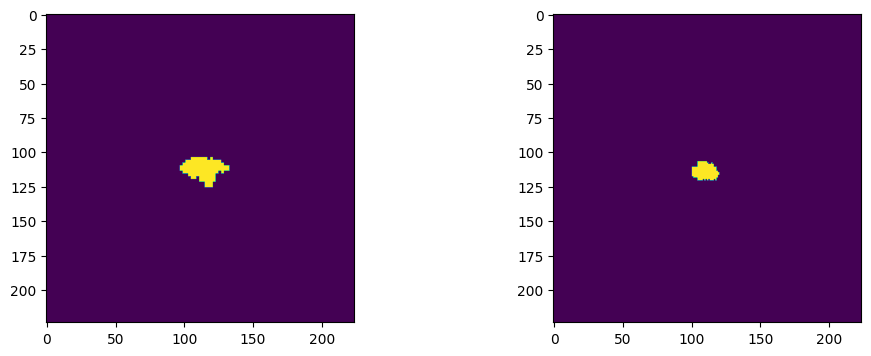

<Figure size 640x480 with 0 Axes>

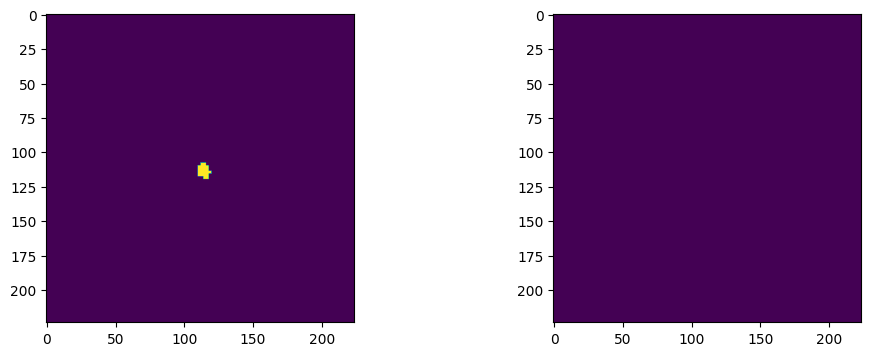

<Figure size 640x480 with 0 Axes>

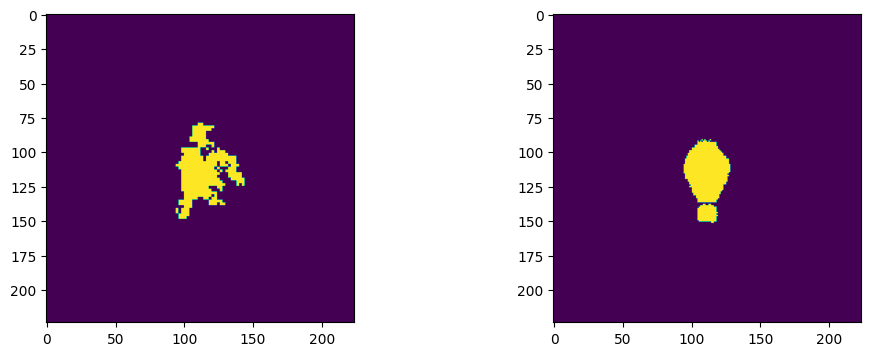

<Figure size 640x480 with 0 Axes>

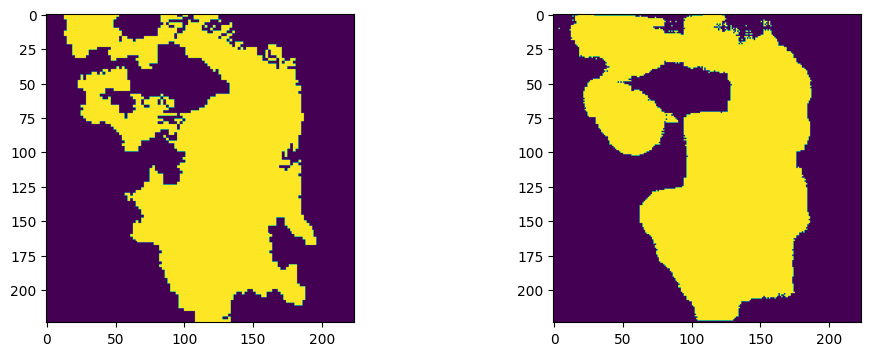

<Figure size 640x480 with 0 Axes>

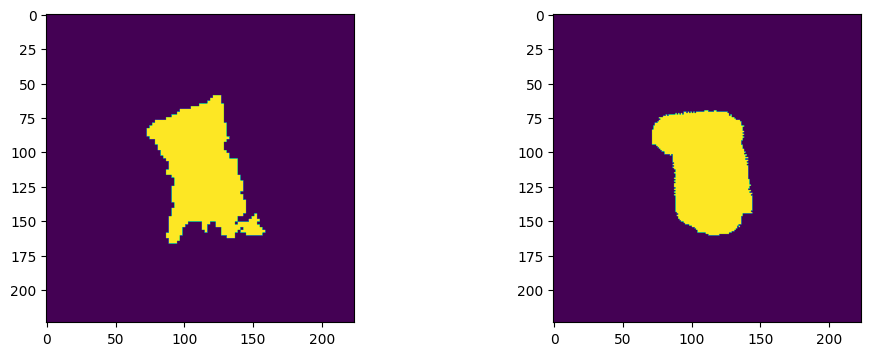

<Figure size 640x480 with 0 Axes>

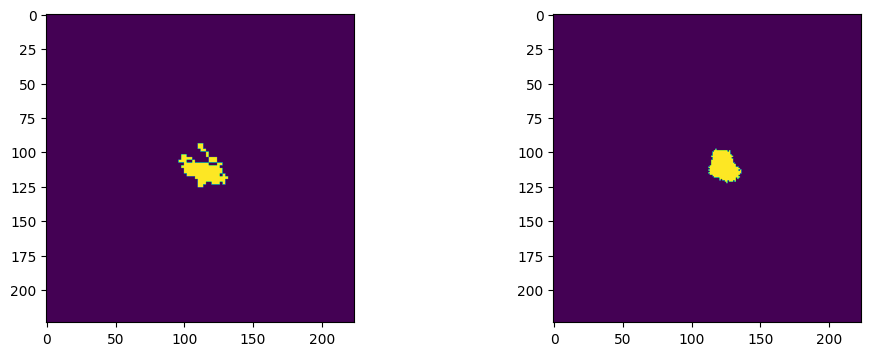

<Figure size 640x480 with 0 Axes>

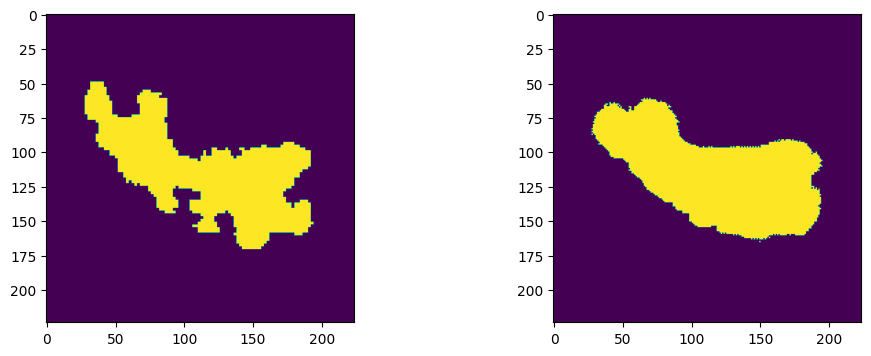

<Figure size 640x480 with 0 Axes>

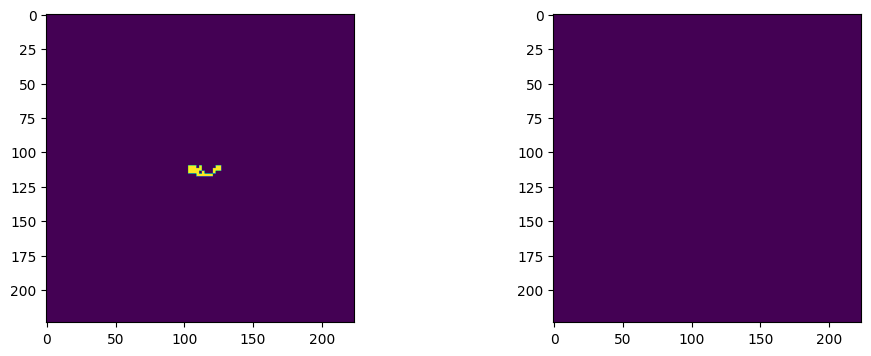

<Figure size 640x480 with 0 Axes>

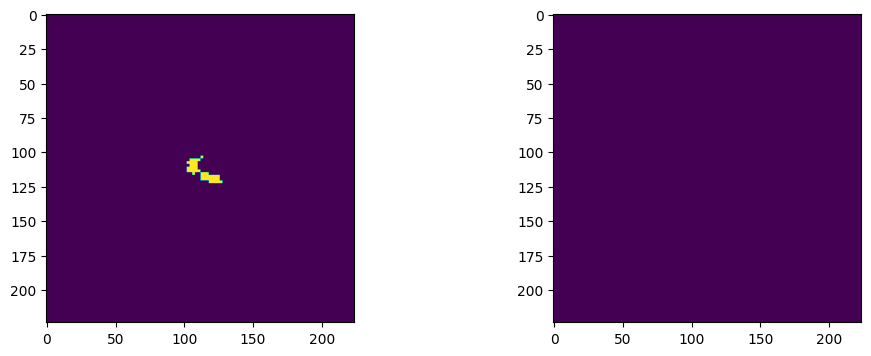

<Figure size 640x480 with 0 Axes>

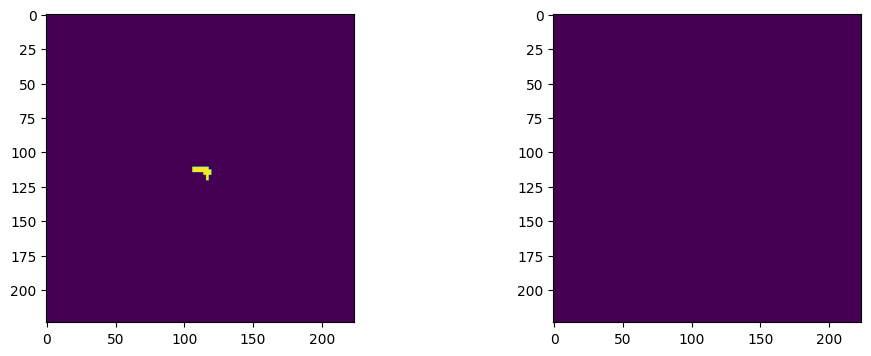

<Figure size 640x480 with 0 Axes>

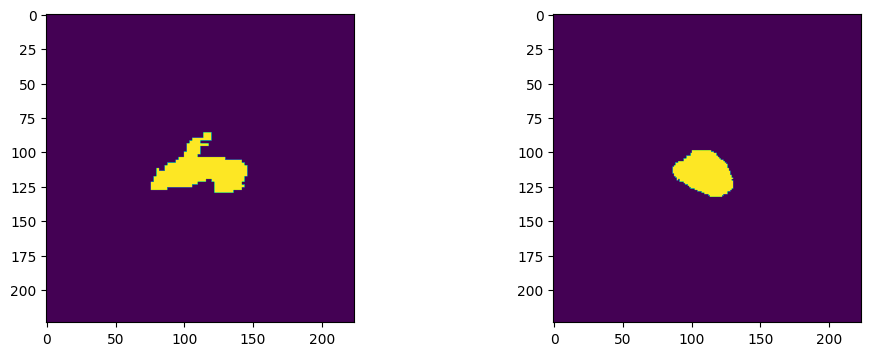

<Figure size 640x480 with 0 Axes>

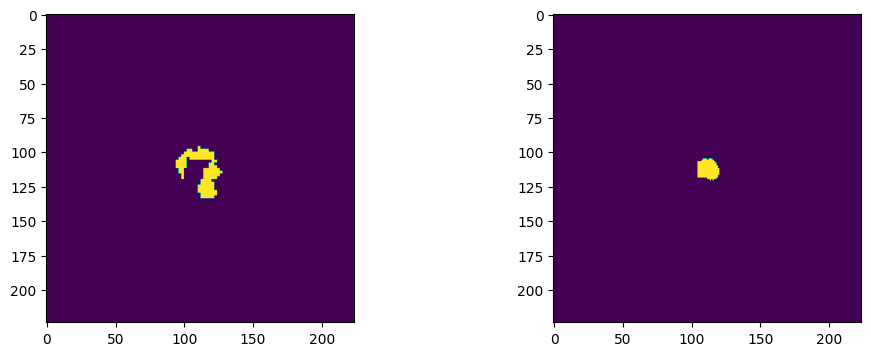

<Figure size 640x480 with 0 Axes>

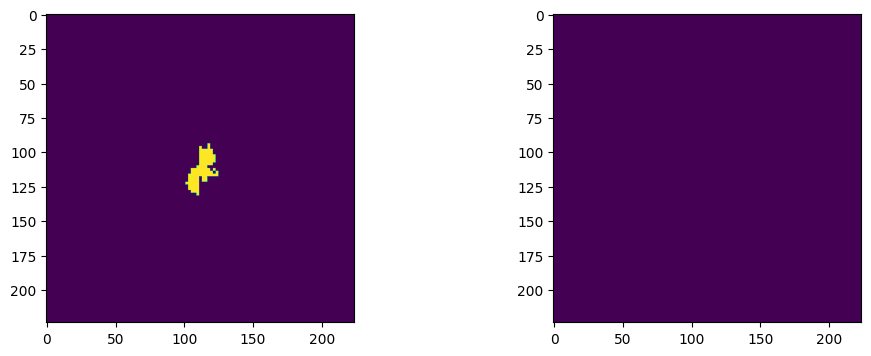

<Figure size 640x480 with 0 Axes>

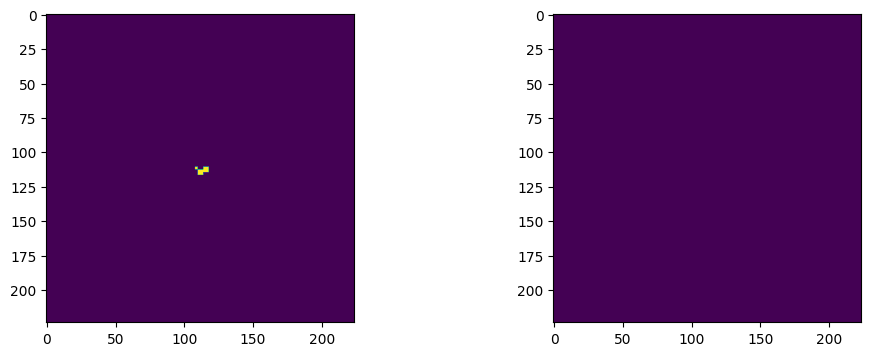

<Figure size 640x480 with 0 Axes>

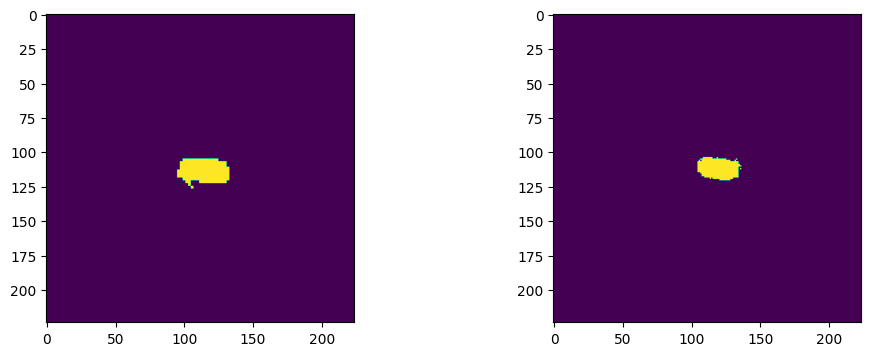

<Figure size 640x480 with 0 Axes>

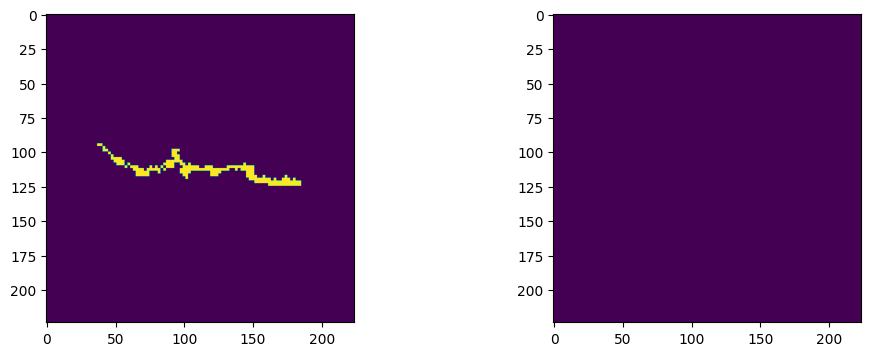

<Figure size 640x480 with 0 Axes>

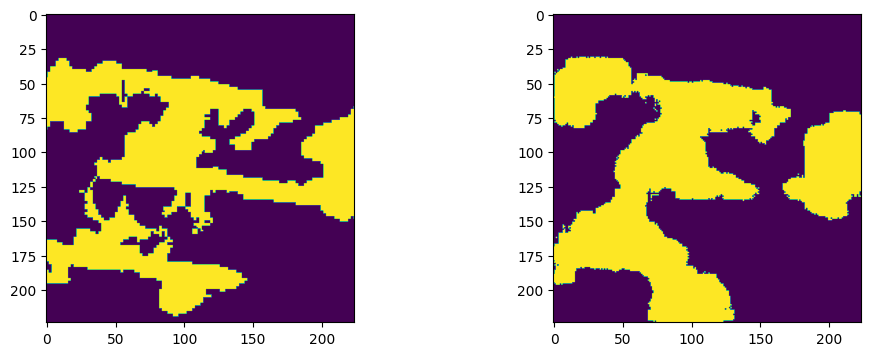

<Figure size 640x480 with 0 Axes>

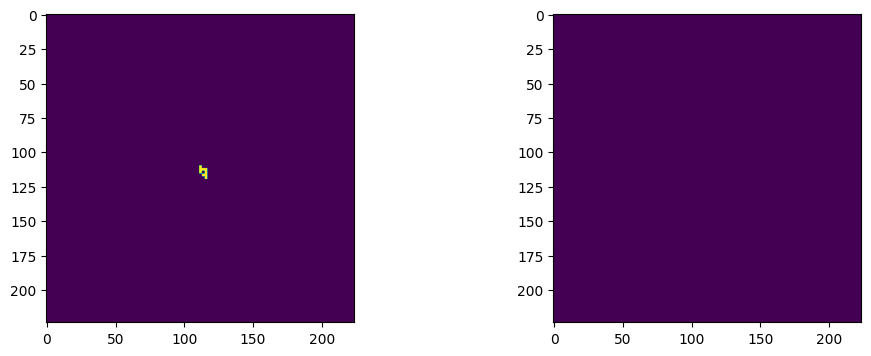

<Figure size 640x480 with 0 Axes>

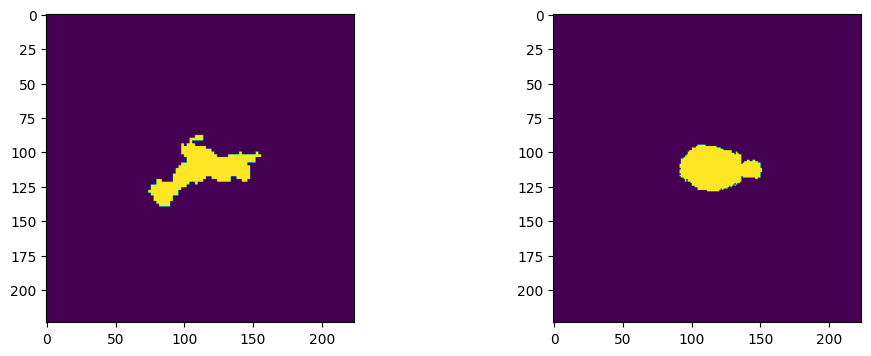

<Figure size 640x480 with 0 Axes>

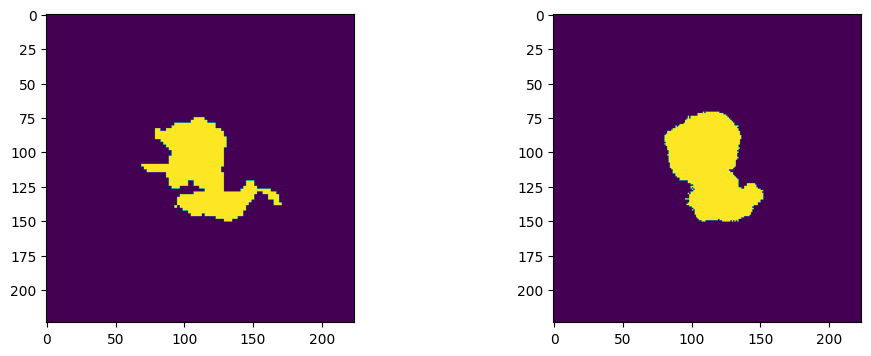

<Figure size 640x480 with 0 Axes>

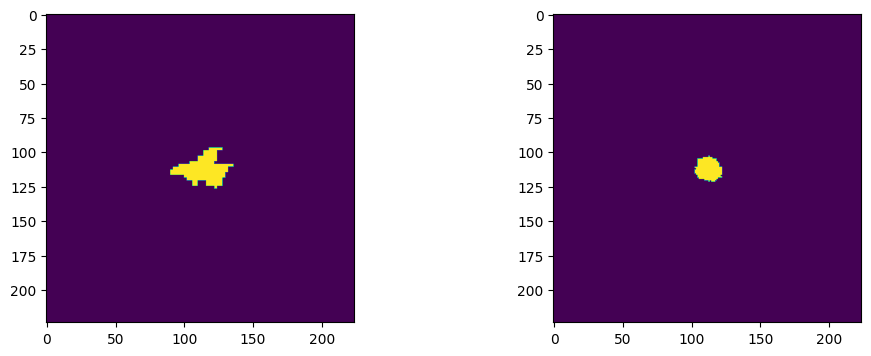

<Figure size 640x480 with 0 Axes>

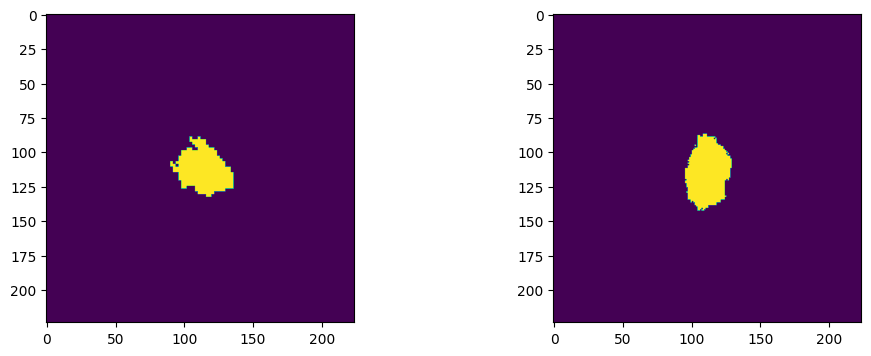

<Figure size 640x480 with 0 Axes>

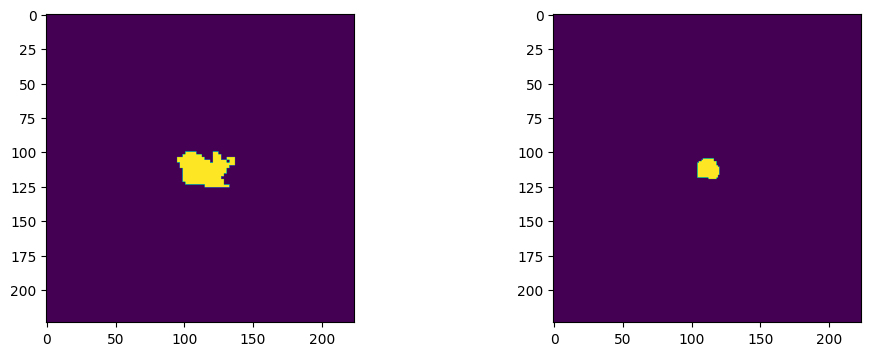

<Figure size 640x480 with 0 Axes>

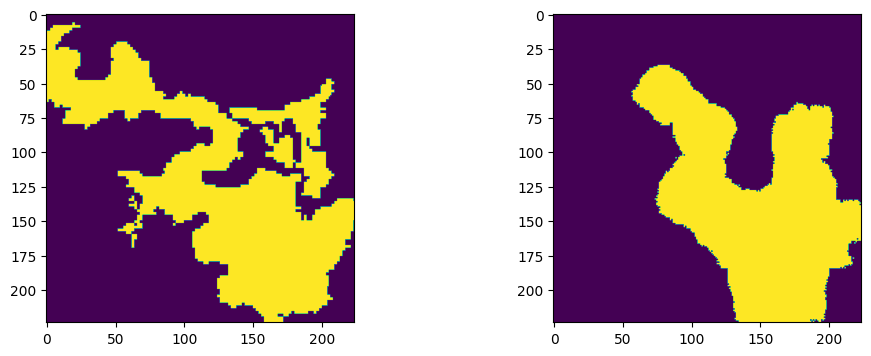

<Figure size 640x480 with 0 Axes>

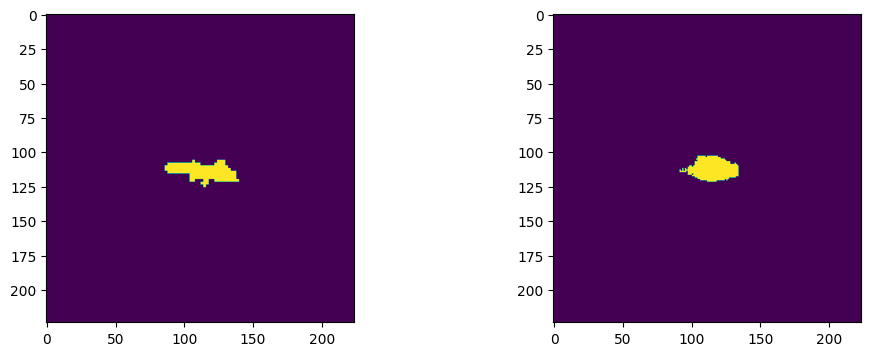

<Figure size 640x480 with 0 Axes>

In [ ]:
seg_real = torch.argmax(seg, dim = 1)
outputs_real = torch.argmax(outputs, dim=1)

for i in range(seg_real.shape[0]):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(seg_real[i].detach().cpu().numpy())
    plt.subplot(1, 2, 2)
    plt.imshow(outputs_real[i].detach().cpu().numpy())

    plt.figure()

In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-4)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model_vit.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images + output_seg

      outputs = model_vit(images)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images + output_seg

            outputs = model_vit(images)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy)#, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),}
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                #}


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new_seperate.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-4)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model_vit.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images + output_seg

      outputs = model_vit(images)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images + output_seg

            outputs = model_vit(images)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy)#, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),}
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                #}


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new_seperate.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

pretrained_resnet_18 = timm.create_model('resnet18', pretrained=True)
num_ftrs = pretrained_resnet_18.get_classifier().in_features
pretrained_resnet_18.fc = nn.Linear(num_ftrs, 4)
pretrained_resnet_18 = nn.Sequential(
    pretrained_resnet_18,
    nn.Softmax(dim=1)  # 在第一维度（列）上应用softmax
)

pretrained_resnet_18 = pretrained_resnet_18.to(device)

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



#seg_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
#seg_criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
#seg_scheduler = torch.optim.lr_scheduler.MultiStepLR(seg_optimizer, milestones=[100,200,300,500], gamma=0.1)




number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")


#ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_pretrained_resnet_18.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

#checkpoint = torch.load(ckpt_for_tr)

#pretrained_resnet_18.load_state_dict(checkpoint['model_state_dict'])

#seg_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#seg_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#model.eval()



pretrained_resnet_18.train()

optimizer = torch.optim.Adam(pretrained_resnet_18.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#seg_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    pretrained_resnet_18.train()
    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      #model.eval()

      #with torch.no_grad():
      #output_final = model(images)

      outputs = pretrained_resnet_18(images)#(output_final)

      loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))

      tp = f1_loss(labels, outputs) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy, Train_F1_Loss = tp.item())#, IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0
        #model.eval()
        pretrained_resnet_18.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            #with torch.no_grad():
            #output_final = model(images)

            outputs = pretrained_resnet_18(images)#(output_final)

            loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))

            tp = f1_loss(labels, outputs)


            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy, VAL_F1_Loss = tp.item())#, IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': pretrained_resnet_18.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_pretrained_resnet_18_2.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 768
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



#seg_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
#seg_criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
#seg_scheduler = torch.optim.lr_scheduler.MultiStepLR(seg_optimizer, milestones=[100,200,300,500], gamma=0.1)




number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")


#ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

#checkpoint = torch.load(ckpt_for_tr)

#model.load_state_dict(checkpoint['model_state_dict'])

#seg_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#seg_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#model.eval()



model_vit.train()

optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model.eval()
    model_vit.train()
    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      #model.eval()

      #with torch.no_grad():
      #output_final = model(images)

      outputs = model_vit(images)#(output_final)

      loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0
        #model.eval()
        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            #with torch.no_grad():
            #output_final = model(images)

            outputs = model_vit(images)#(output_final)

            loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))


            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy)#, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_vit_only.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
#from transformers import Mask2FormerConfig, AutoImageProcessor, Mask2FormerForUniversalSegmentation

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)




number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    model.train()
    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      output_final = model(images)

      loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))

      tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      iou = iou_pytorch(seg, output_final)

      loss = loss+tp

      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(trainloader)
        val_loss = 0
        model.eval()
        for i, (images, labels, seg) in enumerate(pbar):

            output_final = model(images)

            loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))

            tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, output_final)

            loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            '''
            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
            '''

        seg_real = torch.argmax(seg, dim = 1)
        outputs_real = torch.argmax(output_final, dim=1)

        for i in range(seg_real.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(seg_real[i].detach().cpu().numpy())
            plt.subplot(1, 2, 2)
            plt.imshow(outputs_real[i].detach().cpu().numpy())

        print("###### Epoch: ", epoch,"_",val_loss," ######")
        seg_real = torch.argmax(seg, dim = 1)
        outputs_real = torch.argmax(output_final, dim=1)

        for i in range(seg_real.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(seg_real[i].detach().cpu().numpy())
            plt.subplot(1, 2, 2)
            plt.imshow(outputs_real[i].detach().cpu().numpy())

    plt.figure()

    scheduler.step()




In [ ]:
seg_real = torch.argmax(seg, dim = 1)
outputs_real = torch.argmax(output_final, dim=1)

for i in range(seg_real.shape[0]):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(seg_real[i].detach().cpu().numpy())
    plt.subplot(1, 2, 2)
    plt.imshow(outputs_real[i].detach().cpu().numpy())

    plt.figure()